In [11]:
import mdtraj as md
import numpy as np
from scipy.stats import ttest_ind_from_stats

from tqdm import tqdm
from pathlib import Path
import os
from natsort import natsorted
import pandas as pd
from addict import Dict as Adict

import pyemma as pm
import deeptime as dt
import deeptime.markov.msm as msm
import deeptime.markov.hmm as hmm

from deeptime.plots import plot_implied_timescales, plot_energy2d, plot_contour2d_from_xyz
from deeptime.markov.sample import *
from deeptime.markov import TransitionCountEstimator
from deeptime.util import energy2d

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from funcs_build_msm import _tica, get_data 
from funcs_validate_msm import *
from funcs_sample import *
from paths import *

In [3]:
study_name = 'n_clusters'
data_path = Path(f'data_egfr/msm/{study_name}')
summary_f = data_path/f'{study_name}.h5'
hps = pd.read_hdf(summary_f, key='hps')
raw = pd.read_hdf(summary_f, key='result_raw')

summary = raw.groupby('hp_id')[['t2', 'gap_2', 't3', 'gap_3']].agg(['mean', 'std'])
summary

t2                   gap_2                        t3  \
               mean           std      mean        std           mean   
hp_id                                                                   
0      4.258766e+06  4.993950e+06  9.877259  10.570731  438539.507225   
1      2.927477e+06  3.859451e+06  7.083355   7.666884  420395.265777   
2      3.770089e+06  5.647987e+06  8.087046  10.971600  476668.578812   
3      3.775350e+06  5.297374e+06  7.257305   8.182101  513894.618174   

                         gap_3            
                 std      mean       std  
hp_id                                     
0      340220.880011  2.368782  1.164973  
1      355997.202171  2.458528  1.548529  
2      398473.507520  2.461085  1.242254  
3      397912.479254  2.509716  1.214368

In [23]:
means = summary['t2']['mean'].values
sds = summary['t2']['std'].values
n = np.unique(raw['n__boot'])[0]

results = []
for i in range(len(means)):
    for j in range(i+1, len(means)):
        stat, p_value = ttest_ind_from_stats(mean1=means[i], std1=sds[i], nobs1=n,
                                             mean2=means[j], std2=sds[j], nobs2=n)
        results.append(((i+1, j+1), stat, p_value))

results

[((1, 2), 0.943312407610895, 0.35148029701883876),
 ((1, 3), 0.28987652950119963, 0.7734866168161372),
 ((1, 4), 0.29695556454267374, 0.7681176429501108),
 ((2, 3), -0.5508612203946783, 0.5849531790549252),
 ((2, 4), -0.5785301338232524, 0.5663196060390971),
 ((3, 4), -0.00303845817978438, 0.9975915603527046)]

In [76]:
hp_id = 1
hp_dict = Adict(hps[hps.hp_id == hp_id].to_dict('records')[0])
features = ['dbdist', 'dbdihed', 'aloop', 'ploopdihed', 'achelix']

bs = 4
kmeans_f = data_path/f'{hp_id}'/f'bs_{bs}_kmeans_centers.npy'
tmat_f = data_path/f'{hp_id}'/f'bs_{bs}_msm_tmat.npy'

kmeans_centres = np.load(kmeans_f, allow_pickle=True)
print(kmeans_centres.shape)
tmat = np.load(tmat_f, allow_pickle=True)
print(tmat.shape)

savedir = Path(f'data_egfr/msm/validation/{study_name}_hp{hp_id}_bs{bs}')
savedir.mkdir(exist_ok=True, parents=True)

hp_dict

{'hp_id': 1,
 'trajlen__cutoff': 1000,
 'n__boot': 20,
 'seed': 49587,
 'tica__lag': 10,
 'tica__stride': 1000,
 'tica__dim': 20,
 'cluster__k': 5000,
 'cluster__stride': 1000,
 'cluster__maxiter': 1000,
 'markov__lag': 100}

In [77]:
kmeans_centres = np.load(kmeans_f, allow_pickle=True)
print(kmeans_centres.shape)
tmat = np.load(tmat_f, allow_pickle=True)
tmat.shape

(5000, 20)


(5000, 5000)

---

In [5]:
ftrajs, traj_mapping = get_data(trajlen_cutoff=hp_dict.trajlen__cutoff, features=features, ftraj_dir=ftraj_dir)

Loading feature:  dbdist


100%|██████████| 3472/3472 [00:27<00:00, 124.87it/s]


Loading feature:  dbdihed


100%|██████████| 3472/3472 [00:41<00:00, 83.68it/s] 


Loading feature:  aloop


100%|██████████| 3472/3472 [03:49<00:00, 15.10it/s]


Loading feature:  ploopdihed


100%|██████████| 3472/3472 [01:00<00:00, 56.93it/s]


Loading feature:  achelix


100%|██████████| 3472/3472 [00:35<00:00, 97.63it/s] 

Loaded number of ftrajs: 1988


In [71]:
ttrajs, tica_mod = _tica(hp_dict, ftrajs)
ttraj_cat = np.concatenate(ttrajs, axis=0)[:, :3]

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
calculate covariances:   0%|          | 0/1988 [00:00<?, ?it/s]

100%|██████████| 1988/1988 [00:26<00:00, 74.15it/s]                        


In [78]:
kmeans_mod = pm.coordinates.cluster_kmeans()
kmeans_mod.set_model_params(kmeans_centres)
dtrajs = kmeans_mod.transform(ttrajs)
dtrajs = [dtraj.flatten() for dtraj in dtrajs]
dtrajs_cat = np.concatenate(dtrajs, axis=0)

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


In [79]:
tcmat = TransitionCountEstimator(lagtime=hp_dict.markov__lag, count_mode='sliding', n_states=hp_dict.cluster__k).fit_fetch(dtrajs)
print(tcmat.count_matrix.shape) 

stat_dist = dt.markov.tools.analysis.stationary_distribution(tmat)
print(sum(stat_dist))

(5000, 5000)
1.0000000000000022


In [80]:
msm_mod = msm.MarkovStateModel(transition_matrix=tmat, stationary_distribution=stat_dist, lagtime=hp_dict.markov__lag, count_model=tcmat)
traj_weights = msm_mod.compute_trajectory_weights(dtrajs)

---

In [ ]:
its_data = its_convergence(dtrajs, lagtimes=[1,10,50,100,200,500,1000])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_implied_timescales(its_data, n_its=10, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied timescales', fontsize=16)
ax.set_xlabel('Lag time (ns)', fontsize=14)
ax.set_ylabel('Timescale (ns)', fontsize=14)

plt.savefig(data_path.joinpath('its_test.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

---

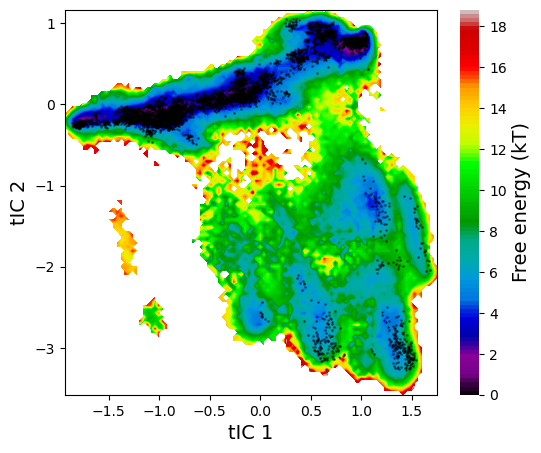

In [81]:
# The directions of tICs are random. Add a minus if it doesn't match with cluster centers

fig, ax = plt.subplots(figsize=(6, 5))
ax, contour, cbar = plot_energy2d(energy2d(ttraj_cat[:,0], ttraj_cat[:,1], weights=np.concatenate(traj_weights, axis=0)), ax=ax, contourf_kws=dict(cmap='nipy_spectral'))
ax.scatter(kmeans_mod.cluster_centers_[:,0], kmeans_mod.cluster_centers_[:,1], s=3, c='black', marker='.', alpha=0.5)
ax.set_xlabel('tIC 1', fontsize=14)
ax.set_ylabel('tIC 2', fontsize=14)
cbar.ax.set_ylabel('Free energy (kT)', fontsize=14)

plt.savefig(savedir/'free_energy.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

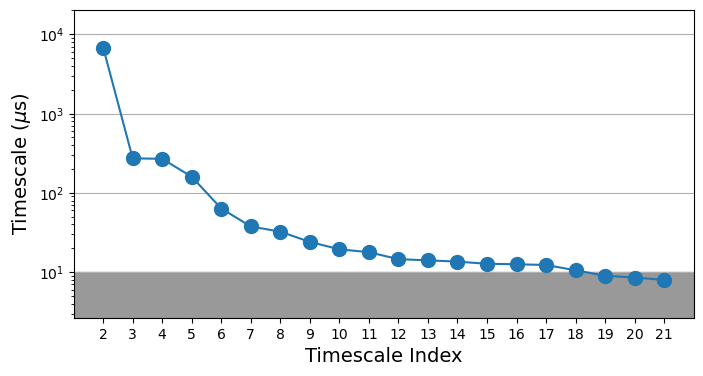

In [82]:
n_ts = 20 

fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(n_ts)+2
y = msm_mod.timescales(n_ts)/1000

ax.plot(x, y, marker='o', markersize=10)
ax.fill_between([0, n_ts+2], y1=10, y2=0, color='grey', alpha=0.8)

ax.set_yscale('log')
ax.grid(visible=True, axis='y')

ax.set_xlim([1, n_ts+2])
ax.set_ylim([min(y)/3, max(y)*3])

ax.set_xticks(np.arange(2, n_ts+2, 1))
ax.set_ylabel(r"Timescale ($\mu$s)", fontsize=14)
ax.set_xlabel(r"Timescale Index", fontsize=14)
ax.tick_params(bottom=True, top=False, left=True, right=False)

plt.savefig(savedir/'timescales.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

### Coarse-grain with PCCA

In [84]:
n_states = 10
pcca_mod = msm_mod.pcca(n_states)
pcca_mod.coarse_grained_stationary_probability

array([0.00050547, 0.00083165, 0.00509868, 0.06018524, 0.01386458,
       0.07804084, 0.06509628, 0.0815965 , 0.28714384, 0.40763692])

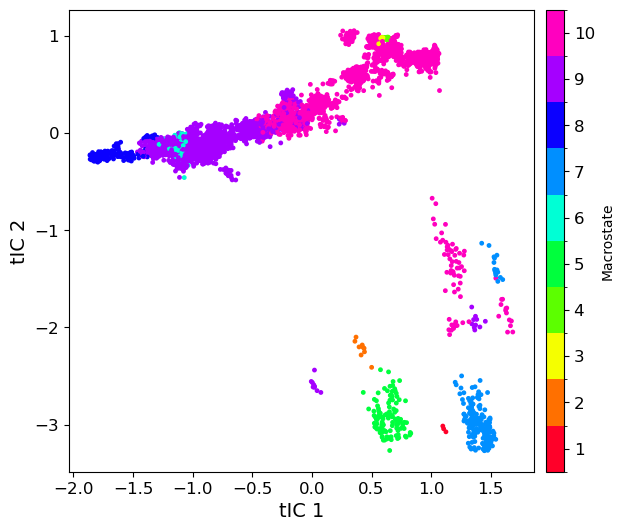

In [85]:
cmap = mpl.colormaps['gist_rainbow'].resampled(n_states)
norm = colors.BoundaryNorm(list(range(0, n_states+1)), n_states, clip=True)

fig, ax=plt.subplots(1,1,figsize=(6, 6))
s = ax.scatter(kmeans_mod.cluster_centers_[:,0], kmeans_mod.cluster_centers_[:,1], 
               c=pcca_mod.assignments, s=6, cmap=cmap, norm=norm)
ax.set_xlabel('tIC 1', fontsize=14)
ax.set_ylabel('tIC 2', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

cbar_ax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.03, ax.get_position().height])
cbar = plt.colorbar(s, cax=cbar_ax, label='Macrostate')
cbar.set_ticks(np.arange(n_states) + 0.5)
cbar.set_ticklabels(np.arange(n_states)+1)
cbar.ax.tick_params(labelsize=12)

plt.savefig(savedir/'macrostate_assignment.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

### Coarse-grained transition matrix and MFPT matrix

In [ ]:
mfpt = np.zeros([n_states, n_states])

for i in range(n_states):
    for j in range(n_states):
        mfpt[i,j] = msm_mod.mfpt(A=pcca_mod.sets[i], B=pcca_mod.sets[j])

In [ ]:
cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=np.min(mfpt_mean/1000), vmax=np.max(mfpt_mean/1000))

fig,ax = plt.subplots(1,figsize=(10,10))
s = ax.imshow(mfpt_mean/1000, cmap=cmap, norm=norm) 
for i in range(n_states):
    for j in range(n_states):        
        ax.text(j, i,"{:.2e}".format(mfpt_mean[i,j]),
                va='center', ha='center', color='white', size=10, weight="bold")

                
cbar_ax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.03, ax.get_position().height])
cbar = plt.colorbar(s, cax=cbar_ax)

ax.set_xlabel('State$_j$', fontsize=18)
ax.set_ylabel('State$_i$', fontsize=18)
ax.set_xticks(np.arange(n_states))
ax.set_yticks(np.arange(n_states))
ax.set_xticklabels(np.arange(n_states)+1, fontsize=14)
ax.set_yticklabels(np.arange(n_states)+1, fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title('MFPT Matrix', fontsize=25)

cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel(r'State$_i$ --> State$_j$ MFPT ($\mathrm{\mu s}$)', fontsize=16)

plt.savefig(savedir/'mfpt_matrix.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

### Eigenvectors

In [ ]:
eigenvec_2 = msm_mod.eigenvectors_right()[:,1]

vmin, vmax = min(eigenvec_2), max(eigenvec_2)
divnorm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

min_id, max_id = eigenvec_2.argmin(), eigenvec_2.argmax()

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_axes([0, 0, 0.5, 0.5])
ax2 = fig.add_axes([0.52, 0, 0.5, 0.5])
fe_cax = fig.add_axes([ax1.get_position().x0-0.08, ax1.get_position().y0, 0.03, ax1.get_position().height])
ev1_cax = fig.add_axes([ax1.get_position().x0, ax1.get_position().y1+0.02, ax1.get_position().width, 0.03])
ev2_cax = fig.add_axes([ax2.get_position().x0, ax2.get_position().y1+0.02, ax2.get_position().width, 0.03])

ax1, contour1, cbar1 = plot_energy2d(energy2d(ttraj_cat[:,0], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax1, cbar_ax=fe_cax, contourf_kws=dict(cmap='nipy_spectral', alpha=0.6))
ax2, contour1, cbar2 = plot_energy2d(energy2d(ttraj_cat[:,2], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax2, cbar=False, contourf_kws=dict(cmap='nipy_spectral', alpha=0.6))

ax1_eg2 = ax1.scatter(kmeans_mod.cluster_centers_[:,0], kmeans_mod.cluster_centers_[:,1], s=20, c=eigenvec_2, marker='.', alpha=0.8, cmap='coolwarm', norm=divnorm)
ax1.scatter(kmeans_mod.cluster_centers_[min_id,0], kmeans_mod.cluster_centers_[min_id,1], s=100, c='k', marker='X', label='min')
ax1.scatter(kmeans_mod.cluster_centers_[max_id,0], kmeans_mod.cluster_centers_[max_id,1], s=100, c='k', marker='v', label='max')
fig.colorbar(ax1_eg2, cax=ev1_cax, format='%.1f', orientation='horizontal')

ax2_eg2 = ax2.scatter(kmeans_mod.cluster_centers_[:,2], kmeans_mod.cluster_centers_[:,1], s=20, c=eigenvec_2, marker='.', alpha=0.8, cmap='coolwarm', norm=divnorm)
ax2.scatter(kmeans_mod.cluster_centers_[min_id,2], kmeans_mod.cluster_centers_[min_id,1], s=100, c='k', marker='X', label='min')
ax2.scatter(kmeans_mod.cluster_centers_[max_id,2], kmeans_mod.cluster_centers_[max_id,1], s=100, c='k', marker='v', label='max')
fig.colorbar(ax2_eg2, cax=ev2_cax, format='%.1f', orientation='horizontal')

ev1_cax.tick_params(axis='x', bottom=False, top=True, labeltop=True, labelbottom=False)
ev2_cax.tick_params(axis='x', bottom=False, top=True, labeltop=True, labelbottom=False)
ax2.tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True)
fe_cax.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)

ax1.set_xlabel('tIC 1', fontsize=14)
ax1.legend()
ax2.set_xlabel('tIC 3', fontsize=14)
ax2.set_ylabel('tIC 2', fontsize=14)
ax2.yaxis.set_label_position("right")
ax2.legend()
ev1_cax.set_xlabel(r'$2^{nd}$ right eigenvector', fontsize=14)
ev2_cax.set_xlabel(r'$2^{nd}$ right eigenvector', fontsize=14)
ev1_cax.xaxis.set_label_position('top')
ev2_cax.xaxis.set_label_position('top')
fe_cax.set_ylabel('Free energy (kT)', fontsize=14)
fe_cax.yaxis.set_label_position("left")

plt.savefig(savedir/'eigenvector_2.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
eigenvec_3 = msm_mod.eigenvectors_right()[:,2]

vmin, vmax = min(eigenvec_3), max(eigenvec_3)
divnorm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

min_id, max_id = eigenvec_3.argmin(), eigenvec_3.argmax()

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_axes([0, 0, 0.5, 0.5])
ax2 = fig.add_axes([0.52, 0, 0.5, 0.5])
fe_cax = fig.add_axes([ax1.get_position().x0-0.08, ax1.get_position().y0, 0.03, ax1.get_position().height])
ev1_cax = fig.add_axes([ax1.get_position().x0, ax1.get_position().y1+0.02, ax1.get_position().width, 0.03])
ev2_cax = fig.add_axes([ax2.get_position().x0, ax2.get_position().y1+0.02, ax2.get_position().width, 0.03])

ax1, contour1, cbar1 = plot_energy2d(energy2d(ttraj_cat[:,0], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax1, cbar_ax=fe_cax, contourf_kws=dict(cmap='nipy_spectral', alpha=0.6))
ax2, contour1, cbar2 = plot_energy2d(energy2d(ttraj_cat[:,2], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax2, cbar=False, contourf_kws=dict(cmap='nipy_spectral', alpha=0.6))

ax1_eg2 = ax1.scatter(kmeans_mod.cluster_centers_[:,0], kmeans_mod.cluster_centers_[:,1], s=20, c=eigenvec_3, marker='.', alpha=0.8, cmap='coolwarm', norm=divnorm)
ax1.scatter(kmeans_mod.cluster_centers_[min_id,0], kmeans_mod.cluster_centers_[min_id,1], s=100, c='k', marker='X', label='min')
ax1.scatter(kmeans_mod.cluster_centers_[max_id,0], kmeans_mod.cluster_centers_[max_id,1], s=100, c='k', marker='v', label='max')
fig.colorbar(ax1_eg2, cax=ev1_cax, format='%.1f', orientation='horizontal')

ax2_eg2 = ax2.scatter(kmeans_mod.cluster_centers_[:,2], kmeans_mod.cluster_centers_[:,1], s=20, c=eigenvec_3, marker='.', alpha=0.8, cmap='coolwarm', norm=divnorm)
ax2.scatter(kmeans_mod.cluster_centers_[min_id,2], kmeans_mod.cluster_centers_[min_id,1], s=100, c='k', marker='X', label='min')
ax2.scatter(kmeans_mod.cluster_centers_[max_id,2], kmeans_mod.cluster_centers_[max_id,1], s=100, c='k', marker='v', label='max')
fig.colorbar(ax2_eg2, cax=ev2_cax, format='%.1f', orientation='horizontal')

ev1_cax.tick_params(axis='x', bottom=False, top=True, labeltop=True, labelbottom=False)
ev2_cax.tick_params(axis='x', bottom=False, top=True, labeltop=True, labelbottom=False)
ax2.tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True)
fe_cax.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)

ax1.set_xlabel('tIC 1', fontsize=14)
ax1.legend()
ax2.set_xlabel('tIC 3', fontsize=14)
ax2.set_ylabel('tIC 2', fontsize=14)
ax2.yaxis.set_label_position("right")
ax2.legend()
ev1_cax.set_xlabel(r'$3^{rd}$ right eigenvector', fontsize=14)
ev2_cax.set_xlabel(r'$3^{rd}$ right eigenvector', fontsize=14)
ev1_cax.xaxis.set_label_position('top')
ev2_cax.xaxis.set_label_position('top')
fe_cax.set_ylabel('Free energy (kT)', fontsize=14)
fe_cax.yaxis.set_label_position("left")

plt.savefig(savedor/'eigenvector_3.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
eigenvec_4 = msm_mod.eigenvectors_right()[:,3]

vmin, vmax = min(eigenvec_4), max(eigenvec_4)
divnorm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

min_id, max_id = eigenvec_4.argmin(), eigenvec_4.argmax()

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_axes([0, 0, 0.5, 0.5])
ax2 = fig.add_axes([0.52, 0, 0.5, 0.5])
fe_cax = fig.add_axes([ax1.get_position().x0-0.08, ax1.get_position().y0, 0.03, ax1.get_position().height])
ev1_cax = fig.add_axes([ax1.get_position().x0, ax1.get_position().y1+0.02, ax1.get_position().width, 0.03])
ev2_cax = fig.add_axes([ax2.get_position().x0, ax2.get_position().y1+0.02, ax2.get_position().width, 0.03])

ax1, contour1, cbar1 = plot_energy2d(energy2d(ttraj_cat[:,0], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax1, cbar_ax=fe_cax, contourf_kws=dict(cmap='nipy_spectral', alpha=0.6))
ax2, contour1, cbar2 = plot_energy2d(energy2d(ttraj_cat[:,2], ttraj_cat[:,1], weights=np.concatenate(traj_weights,axis=0)), ax=ax2, cbar=False, contourf_kws=dict(cmap='nipy_spectral', alpha=0.6))

ax1_eg4 = ax1.scatter(kmeans_mod.cluster_centers_[:,0], kmeans_mod.cluster_centers_[:,1], s=20, c=eigenvec_4, marker='.', alpha=0.8, cmap='coolwarm', norm=divnorm)
ax1.scatter(kmeans_mod.cluster_centers_[min_id,0], kmeans_mod.cluster_centers_[min_id,1], s=100, c='k', marker='X', label='min')
ax1.scatter(kmeans_mod.cluster_centers_[max_id,0], kmeans_mod.cluster_centers_[max_id,1], s=100, c='k', marker='v', label='max')
fig.colorbar(ax1_eg4, cax=ev1_cax, format='%.1f', orientation='horizontal')

ax2_eg4 = ax2.scatter(kmeans_mod.cluster_centers_[:,2], kmeans_mod.cluster_centers_[:,1], s=20, c=eigenvec_4, marker='.', alpha=0.8, cmap='coolwarm', norm=divnorm)
ax2.scatter(kmeans_mod.cluster_centers_[min_id,2], kmeans_mod.cluster_centers_[min_id,1], s=100, c='k', marker='X', label='min')
ax2.scatter(kmeans_mod.cluster_centers_[max_id,2], kmeans_mod.cluster_centers_[max_id,1], s=100, c='k', marker='v', label='max')
fig.colorbar(ax2_eg4, cax=ev2_cax, format='%.1f', orientation='horizontal')

ev1_cax.tick_params(axis='x', bottom=False, top=True, labeltop=True, labelbottom=False)
ev2_cax.tick_params(axis='x', bottom=False, top=True, labeltop=True, labelbottom=False)
ax2.tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True)
fe_cax.tick_params(axis='y', left=True, right=False, labelleft=True, labelright=False)

ax1.set_xlabel('tIC 1', fontsize=14)
ax1.legend()
ax2.set_xlabel('tIC 3', fontsize=14)
ax2.set_ylabel('tIC 2', fontsize=14)
ax2.yaxis.set_label_position("right")
ax2.legend()
ev1_cax.set_xlabel(r'$4^{th}$ right eigenvector', fontsize=14)
ev2_cax.set_xlabel(r'$4^{th}$ right eigenvector', fontsize=14)
ev1_cax.xaxis.set_label_position('top')
ev2_cax.xaxis.set_label_position('top')
fe_cax.set_ylabel('Free energy (kT)', fontsize=14)
fe_cax.yaxis.set_label_position("left")

plt.savefig(savedir/'eigenvector_4.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

---

In [ ]:
macrostate_to_sample = 0
membership_cutoff = 0.9

memberships = pcca_mod.memberships[:,macrostate_to_sample]
states_to_sample = memberships > membership_cutoff

stationary_distribution = msm_mod.stationary_distribution
stationary_distribution[~states_to_sample] = 0
sample_distribution = stationary_distribution / np.sum(stationary_distribution)

state_samples_count = sample_states_by_distribution(sample_distribution, 10)
print(state_samples_count)
samples = sample_frames_by_states(state_samples_count, dtrajs, mapping=traj_mapping)
save_samples(samples, traj_files, data_path/'MS_0.pdb')